In [6]:
import os
from skimage.io import imread, imsave
from skimage.transform import resize
import numpy as np

def normalize_images_in_folders(input_root, output_root, target_size=(128, 128)):
    
    for subdir, _, files in os.walk(input_root):
        
        relative_path = os.path.relpath(subdir, input_root)
        output_subdir = os.path.join(output_root, relative_path)
        os.makedirs(output_subdir, exist_ok=True)

        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                input_path = os.path.join(subdir, file)
                output_path = os.path.join(output_subdir, file)

                try:
                    # Leer la imagen
                    image = imread(input_path)

                    #Validar dimensiones
                    if image.ndim == 2:  #Escala de grises
                        image = np.stack((image,) * 3, axis=-1)
                    elif image.ndim != 3 or image.shape[2] != 3:
                        print(f"Formato inesperado en {input_path}, ignorando...")
                        continue

                    #Redimensionar y guardar
                    image_resized = resize(
                        image, target_size, anti_aliasing=True, preserve_range=True
                    )
                    image_resized = np.clip(image_resized, 0, 255).astype(np.uint8)
                    imsave(output_path, image_resized)
                    print(f"Guardada imagen normalizada en {output_path}")
                except Exception as e:
                    print(f"Error al procesar {input_path}: {e}")

    print(f"Todas las imágenes han sido procesadas y guardadas en {output_root}")

input_root = "C:\Users\roman\Documents\Inteligencia Artificial\Ejercicios\Carritos\imagenes_pinterest\Chevrolet Aveo N"
output_root = "./dataset_2128"
normalize_images_in_folders(input_root, output_root)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (479294622.py, line 42)

# Convolutional Neural Networks

# Importar Librerías

In [9]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [10]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU

from skimage.io import imread, imsave
from skimage.transform import resize

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D

# Cargar set de Imágenes

In [11]:
"""
dirname = os.path.join(os.getcwd(),'/home/likcos/DataSets/sportimages/sportimages')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            if(len(image.shape)==3):
                
                images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))
"""

imgpath = 'C:/Users/roman/Documents/Inteligencia Artificial/Ejercicios/Carritos/imagenes_pinterest/Chevrolet Aveo N'

images = []
directories = []
dircount = []
cant = 0

print("Leyendo imágenes de", imgpath)

# Recorrer directorios e imágenes
for root, _, filenames in os.walk(imgpath):
    # Filtrar solo los archivos válidos
    valid_images = [f for f in filenames if re.search(r"\.(jpg|jpeg|png|bmp|tiff)$", f, re.IGNORECASE)]
    if valid_images:
        directories.append(root)  # Agregar el directorio actual
        dircount.append(len(valid_images))  # Contar imágenes en este directorio
        for filename in valid_images:
            filepath = os.path.join(root, filename)
            try:
                image = plt.imread(filepath)
                if len(image.shape) == 2:  # Imagen en escala de grises
                    image = np.stack((image,) * 3, axis=-1)  # Convertir a RGB
                images.append(image)
            except Exception as e:
                print(f"Error al leer {filepath}: {e}")

# Resultado final
print('Directorios leídos:', len(directories))
print("Imágenes en cada directorio:", dircount)
print('Suma total de imágenes en subdirectorios:', sum(dircount))

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
C:\Users\roman\AppData\Local\Temp\ipykernel_24380\3563775295.py:1: SyntaxWarning: invalid escape sequence '\.'
  """


Leyendo imágenes de C:/Users/roman/Documents/Inteligencia Artificial/Ejercicios/Carritos/imagenes_pinterest/Chevrolet Aveo N
Directorios leídos: 1
Imágenes en cada directorio: [103]
Suma total de imágenes en subdirectorios: 103


# Creamos las etiquetas

In [12]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  103


In [13]:
carritos=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    carritos.append(name[len(name)-1])
    indice=indice+1

0 C:/Users/roman/Documents/Inteligencia Artificial/Ejercicios/Carritos/imagenes_pinterest/Chevrolet Aveo N


In [14]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy



# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  1
Output classes :  [0]


# Creamos Sets de Entrenamiento y Test

In [15]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (82, 128, 128, 3) (82,)
Testing data shape :  (21, 128, 128, 3) (21,)


Text(0.5, 1.0, 'Ground Truth : 0')

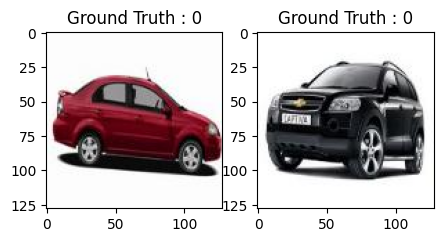

In [16]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

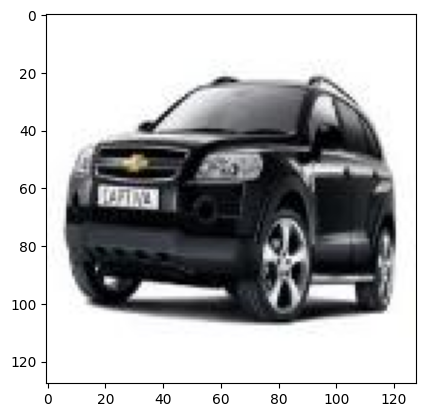

In [17]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [18]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 0
After conversion to one-hot: [1.]


# Creamos el Set de Entrenamiento y Validación

In [19]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [20]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(65, 128, 128, 3) (17, 128, 128, 3) (65, 1) (17, 1)


# Creamos el modelo de CNN

In [21]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 25 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [22]:
"""
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))


sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))
"""

carros_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(nClasses, activation='softmax')
])

c:\Users\roman\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
carros_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 0, 0, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 0, 0, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 0)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,929 (1.48 MB)

 Trainable params: 388,929 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
#sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reducir a la mitad
    patience=5,  # Si no mejora en 5 épocas
    min_lr=1e-6
)

carros_model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR),
    metrics=['accuracy']
)

# Entrenamos el modelo: Aprende a clasificar imágenes

In [25]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
sport_train = carros_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/25


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 0, but received input with shape (None, 9216)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)
  • training=True
  • mask=None

In [ ]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
carros_model.save("C:/Users/roman/Documents/Inteligencia Artificial/Ejercicios/Carritos/Red neuronal/carritos.keras")

# Evaluamos la red

In [ ]:
test_eval = carros_model.evaluate(test_X, test_Y_one_hot, verbose=1)

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

In [ ]:
sport_train.history

In [ ]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
predicted_classes2 = carros_model.predict(test_X)

In [ ]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [ ]:
predicted_classes.shape, test_Y.shape

# Aprendamos de los errores: Qué mejorar

In [ ]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(carritos[predicted_classes[correct]],
                                                    carritos[test_Y[correct]]))

    plt.tight_layout()

In [ ]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(carritos[predicted_classes[incorrect]],
                                                    carritos[test_Y[incorrect]]))
    plt.tight_layout()

In [ ]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

In [ ]:
from skimage.transform import resize

images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
filenames = ['test/golf_0113.jpg']

for filepath in filenames:
    image = plt.imread(filepath,0)
    image_resized = resize(image, (64, 64),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = carros_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], carritos[img_tagged.tolist().index(max(img_tagged))])